# Feature Space Analysis
## References:
Keras documentation: https://keras.io/examples/vision/semantic_image_clustering/


In [1]:
# IMPORT ALL LIBRARIES

import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

from collections import defaultdict
from tqdm import tqdm

## Load the data


In [2]:
# Set sample rate to work with at 8000

SR = 16000

In [3]:
!git clone https://github.com/DavidCastello/NBAC.git

Cloning into 'NBAC'...
remote: Enumerating objects: 798, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 798 (delta 4), reused 148 (delta 2), pack-reused 647
Receiving objects: 100% (798/798), 474.50 MiB | 26.62 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Updating files: 100% (783/783), done.


In [4]:
def map_subfolders_to_int(path):
    reversed_labels = {}
    counter = 0

    # Walk through the directory
    for root, dirs, files in os.walk(path):
        # For each subdirectory
        for dir in dirs:
            # Add the subdirectory to the dictionary with the current count as the key
            reversed_labels[counter] = dir
            counter += 1

    return reversed_labels

# Specify your directory path here
directory_path = "/kaggle/working/NBAC/audio"
reversed_labels = map_subfolders_to_int(directory_path)
print(reversed_labels)

{0: 'loud breathing', 1: 'snoring', 2: 'traffic', 3: 'coughing', 4: 'bed movement', 5: 'sneezing', 6: 'wind', 7: 'siren', 8: 'silence', 9: 'train', 10: 'dog bark', 11: 'talking', 12: 'rain'}


In [5]:
NUM_CLASSES = len(reversed_labels)

In [6]:
def reverse_dict(original_dict):
    reversed_dict = {value: key for key, value in original_dict.items()}
    return reversed_dict

# reversed dictionary
labels_dict = reverse_dict(reversed_labels)
print(labels_dict)

{'loud breathing': 0, 'snoring': 1, 'traffic': 2, 'coughing': 3, 'bed movement': 4, 'sneezing': 5, 'wind': 6, 'siren': 7, 'silence': 8, 'train': 9, 'dog bark': 10, 'talking': 11, 'rain': 12}


### Load the wav files

In [7]:
NBAC_FOLDER = '/kaggle/working/NBAC/audio'

In [8]:
def wav_data_loader(directory, sr=SR, normalization=True):
    all_fragments = []
    for root, dirs, _ in os.walk(directory):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]
            for file in files:
                file_path = os.path.join(dir_path, file)
                # Load the audio file
                sample, sample_rate = librosa.load(file_path, sr=sr)
                if normalization:
                    # Normalize the waveform
                    sample = librosa.util.normalize(sample)
                # Append the sample and its label (subfolder name) as a tuple
                all_fragments.append((sample, labels_dict[dir]))
    return all_fragments

In [9]:
%%time
nbac_wav_dataset = wav_data_loader(NBAC_FOLDER, normalization=False)
len(nbac_wav_dataset)

CPU times: user 13 s, sys: 842 ms, total: 13.9 s
Wall time: 16.6 s


780

## Get spectrograms

In [10]:
def tf_mel_spectrogram(wav, sample_rate=SR, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001):
    
    # Convert numpy array to Tensor and normalize based on its actual max and min values
    wav = tf.cast(wav, tf.float32)
    audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1

    # Calculate the frame_length and frame_step based on window size and hop size
    frame_length = int(sample_rate * 0.025)  # 25 ms window
    frame_step = int(sample_rate * 0.01)  # 10 ms hop

    # Calculate the spectrogram
    spectrogram = tf.signal.stft(audio_tensor, frame_length=frame_length, frame_step=frame_step, window_fn=tf.signal.hann_window)

    # Calculate the magnitude of the spectrogram
    magnitude_spectrogram = tf.abs(spectrogram)

    # Define the parameters for the Mel scale
    num_spectrogram_bins = magnitude_spectrogram.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lower_freq, upper_freq)

    # Convert the spectrogram to the Mel scale
    mel_spectrogram = tf.tensordot(magnitude_spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(magnitude_spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Apply a logarithmic scale
    log_mel_spectrogram = tf.math.log(mel_spectrogram + log_offset)
    
    log_mel_spectrogram = tf.expand_dims(log_mel_spectrogram, -1)
    
    log_mel_spectrogram = tf.repeat(log_mel_spectrogram, 3, axis=-1)

    return log_mel_spectrogram.numpy()

In [11]:
X = [wav[0] for wav in nbac_wav_dataset]
y = [wav[1] for wav in nbac_wav_dataset]

In [12]:
%%time

X_specs = list(map(lambda x: tf_mel_spectrogram(x), X))

CPU times: user 26.6 s, sys: 2.85 s, total: 29.5 s
Wall time: 34.2 s


## Defining the encoder

In [13]:
from tensorflow.keras.models import load_model

# Load the model from the h5 file
trained_model = load_model('/kaggle/input/model-specs-mobilenet/model_specs_mobilenet_imagenet.h5')

In this case, our encoder is already well trained, and we assume it is able to get the features of the spectrograms well enough. For complete self-supervised training, we should run the SimSiam learner or a different one.

In [14]:
trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1024)              3228864   
                                                                 
 dense (Dense)               (None, 13)                13325     
                                                                 
 activation (Activation)     (None, 13)                0         
                                                                 
Total params: 3,242,189
Trainable params: 3,206,285
Non-trainable params: 35,904
_________________________________________________________________


In [15]:
def create_encoder(model):
    # Extract the layers till GlobalAveragePooling2D in MobileNet_embeddings
    mobilenet_with_pooling_model = model.layers[0]
    # Create a new model with inputs as the MobileNet's input and outputs as the GlobalAveragePooling2D layer's output
    encoder = Model(mobilenet_with_pooling_model.input, mobilenet_with_pooling_model.layers[-1].output)
    encoder.trainable = False
    return encoder

# Create the encoder
encoder = create_encoder(trained_model)

In [16]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224_input (I  [(None, 498, 64, 3)]     0         
 nputLayer)                                                      
                                                                 
 mobilenet_1.00_224 (Functio  (None, 15, 2, 1024)      3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 3,228,864
Trainable params: 0
Non-trainable params: 3,228,864
_________________________________________________________________


## Semantic image clustering

In [17]:
!pip install tensorflow-addons

In [18]:
import tensorflow_addons as tfa

In [19]:
data = np.array(X_specs, dtype=object)

In [20]:
x_data = np.array(X_specs)
y_data = y

### Compute the nearest neighbors

In [21]:
num_clusters = NUM_CLASSES  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

In [22]:
batch_size = len(x_data)

# Get the feature vector representations of the images.
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
#feature_vectors = tf.math.l2_normalize(feature_vectors, -1)

1/1 [==============================] - 13s 13s/step


In [23]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size

for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])
    
neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))

100%|██████████| 1/1 [00:00<00:00, 56.34it/s]


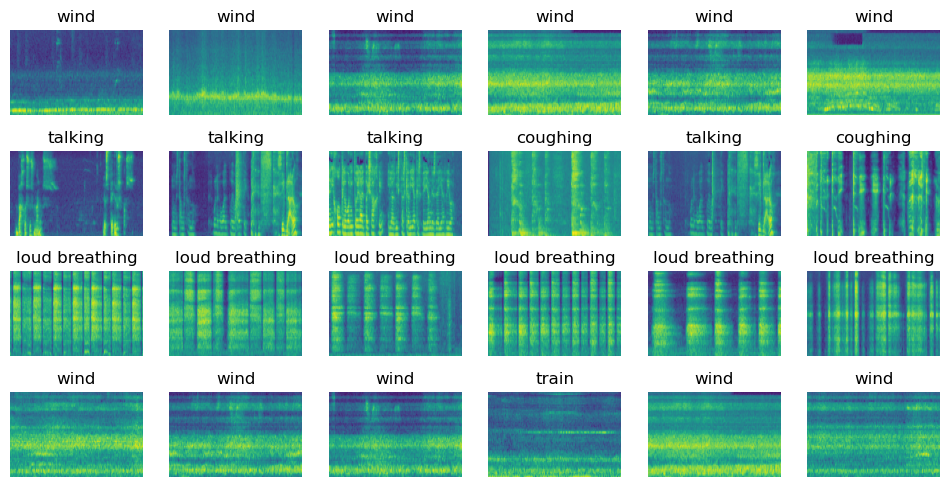

In [24]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 6))
position = 1

for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_data.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        # Select one channel (channel 0), rotate and display with viridis colormap.
        plt.imshow(np.rot90(x_data[indices[j], :, :, 0]), cmap='viridis', aspect=5)
        plt.title(reversed_labels[y_data[indices[j]]])
        plt.axis("off")
        position += 1
        
plt.savefig('foo.png')

### Clustering model

In [25]:
class ClustersConsistencyLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = tf.ones_like(similarity)
        # Compute cross entropy loss.
        loss = tf.keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return tf.math.reduce_mean(loss)

In [26]:
class ClustersEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super().__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = tf.cast(tf.shape(cluster_probabilities)[-1], tf.dtypes.float32)
        target = tf.math.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = tf.math.reduce_mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = tf.clip_by_value(
            cluster_probabilities, clip_value_min=1e-8, clip_value_max=1.0
        )
        # Compute the entropy over the clusters.
        entropy = -tf.math.reduce_sum(
            cluster_probabilities * tf.math.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss

In [27]:
def create_clustering_model(encoder, num_clusters, name=None):
    inputs = tf.keras.Input(shape=input_shape)
    # Preprocess the input images.
    #preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    #augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(inputs)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [28]:
def create_clustering_learner(clustering_model):
    anchor = tf.keras.Input(shape=input_shape, name="anchors")
    neighbours = tf.keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = tf.reshape(neighbours, shape=tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = tf.reshape(
        neighbours_clustering,
        shape=(-1, k_neighbours, tf.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = tf.linalg.einsum(
        "bij,bkj->bik", tf.expand_dims(anchor_clustering, axis=1), neighbours_clustering
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="similarity")(
        similarity
    )
    # Create the model.
    model = tf.keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model

In [29]:
input_shape = x_data[0].shape

Fine tunning: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [30]:
for l in encoder.layers:
    print(l.name, l.trainable)

mobilenet_1.00_224_input False
mobilenet_1.00_224 False
global_average_pooling2d False


In [31]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.

for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
    
# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)

# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]

# Create the model inputs and labels.
inputs = {"anchors": x_data, "neighbours": tf.gather(x_data, neighbours)}
labels = tf.ones(shape=(x_data.shape[0]))

# Compile the model.
clustering_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0005/2, weight_decay=0.0001*2),
    loss=losses,
)

# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=25, epochs=100)

Epoch 1/100
32/32 [==============================] - 10s 119ms/step - loss: 0.6850 - similarity_loss: 0.5881 - clustering_loss: 0.0968
Epoch 2/100
32/32 [==============================] - 3s 106ms/step - loss: 0.6420 - similarity_loss: 0.5752 - clustering_loss: 0.0668
Epoch 3/100
32/32 [==============================] - 3s 103ms/step - loss: 0.6280 - similarity_loss: 0.5575 - clustering_loss: 0.0705
Epoch 4/100
32/32 [==============================] - 4s 114ms/step - loss: 0.6347 - similarity_loss: 0.5422 - clustering_loss: 0.0925
Epoch 5/100
32/32 [==============================] - 3s 106ms/step - loss: 0.6234 - similarity_loss: 0.5357 - clustering_loss: 0.0877
Epoch 6/100
32/32 [==============================] - 3s 104ms/step - loss: 0.6141 - similarity_loss: 0.5131 - clustering_loss: 0.1010
Epoch 7/100
32/32 [==============================] - 3s 106ms/step - loss: 0.5899 - similarity_loss: 0.4984 - clustering_loss: 0.0916
Epoch 8/100
32/32 [==============================] - 3s 107ms

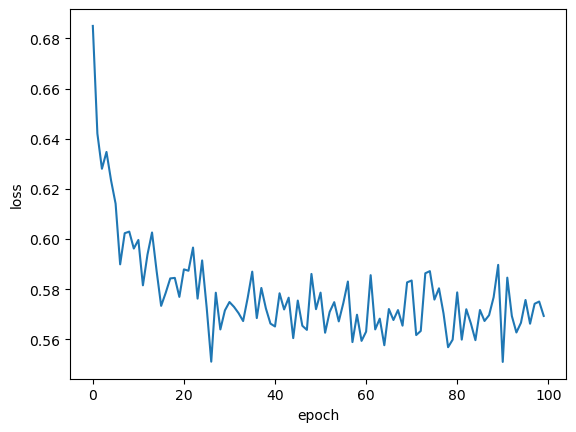

In [32]:
plt.plot(clustering_learner.history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [33]:
clustering_model.summary()

Model: "clustering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 498, 64, 3)]      0         
                                                                 
 model (Functional)          (None, 1024)              3228864   
                                                                 
 dense (Dense)               (None, 13)                13325     
                                                                 
Total params: 3,242,189
Trainable params: 13,325
Non-trainable params: 3,228,864
_________________________________________________________________


In [34]:
clustering_model.save('cluster_model.h5')

In [35]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(x_data, batch_size=batch_size, verbose=1)

# Get the cluster of the highest probability.
cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()

# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.

cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()

1/1 [==============================] - 1s 767ms/step


In [36]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))

cluster 0 : 60
cluster 1 : 58
cluster 2 : 54
cluster 3 : 60
cluster 4 : 70
cluster 5 : 85
cluster 6 : 57
cluster 7 : 17
cluster 8 : 94
cluster 9 : 51
cluster 10 : 65
cluster 11 : 9
cluster 12 : 100


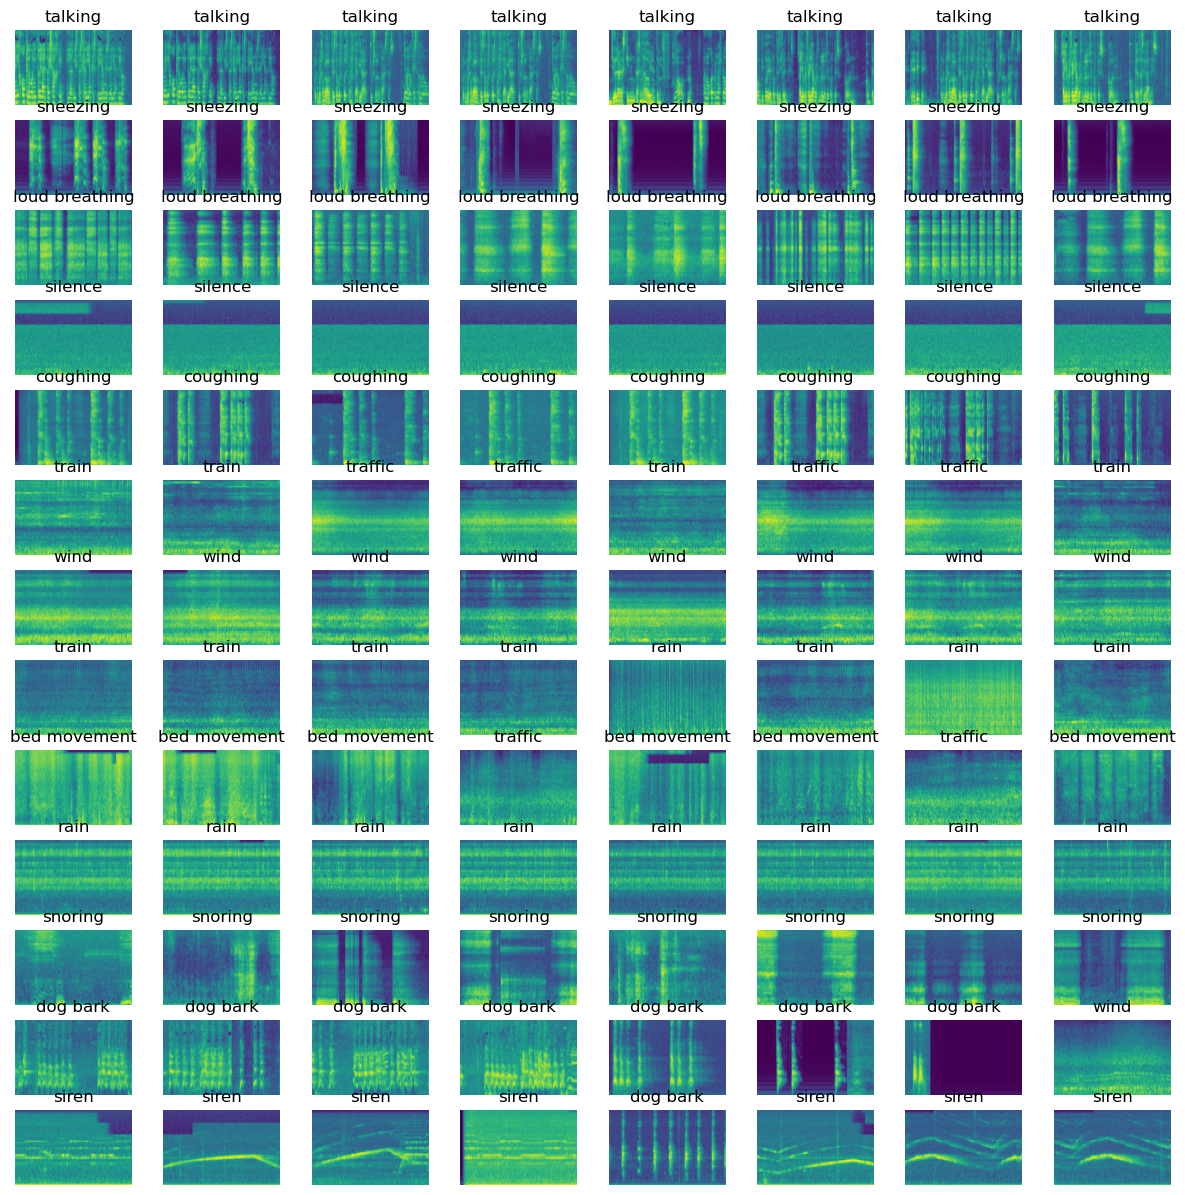

In [37]:
num_images = 8
plt.figure(figsize=(15, 15))
position = 1

for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(num_clusters, num_images, position)
        # Select one channel (channel 0), rotate and display with viridis colormap.
        plt.imshow(np.rot90(x_data[image_idx, :, :, 0]), cmap='viridis', aspect=5)
        plt.title(reversed_labels[y_data[image_idx]])
        plt.axis("off")
        position += 1

plt.savefig('final_clusters.png')

In [38]:
cluster_eval = []

for i in range(len(clusters)):
    for item in clusters[i]:
        cluster_eval.append((y_data[item[0]],i,item[1])) # (True label, predicted cluster)

df = pd.DataFrame(cluster_eval, columns=['Label', 'Predicted Cluster', 'Confidence'])

df.head()

Label  Predicted Cluster  Confidence
0     10                  0    0.272385
1     11                  0    0.907727
2     11                  0    0.904558
3     11                  0    0.758066
4     11                  0    0.988749

In [39]:
# Define high confidence threshold

df_high = df[df['Confidence'] > 0.8]
df_low = df[df['Confidence'] <= 0.8]

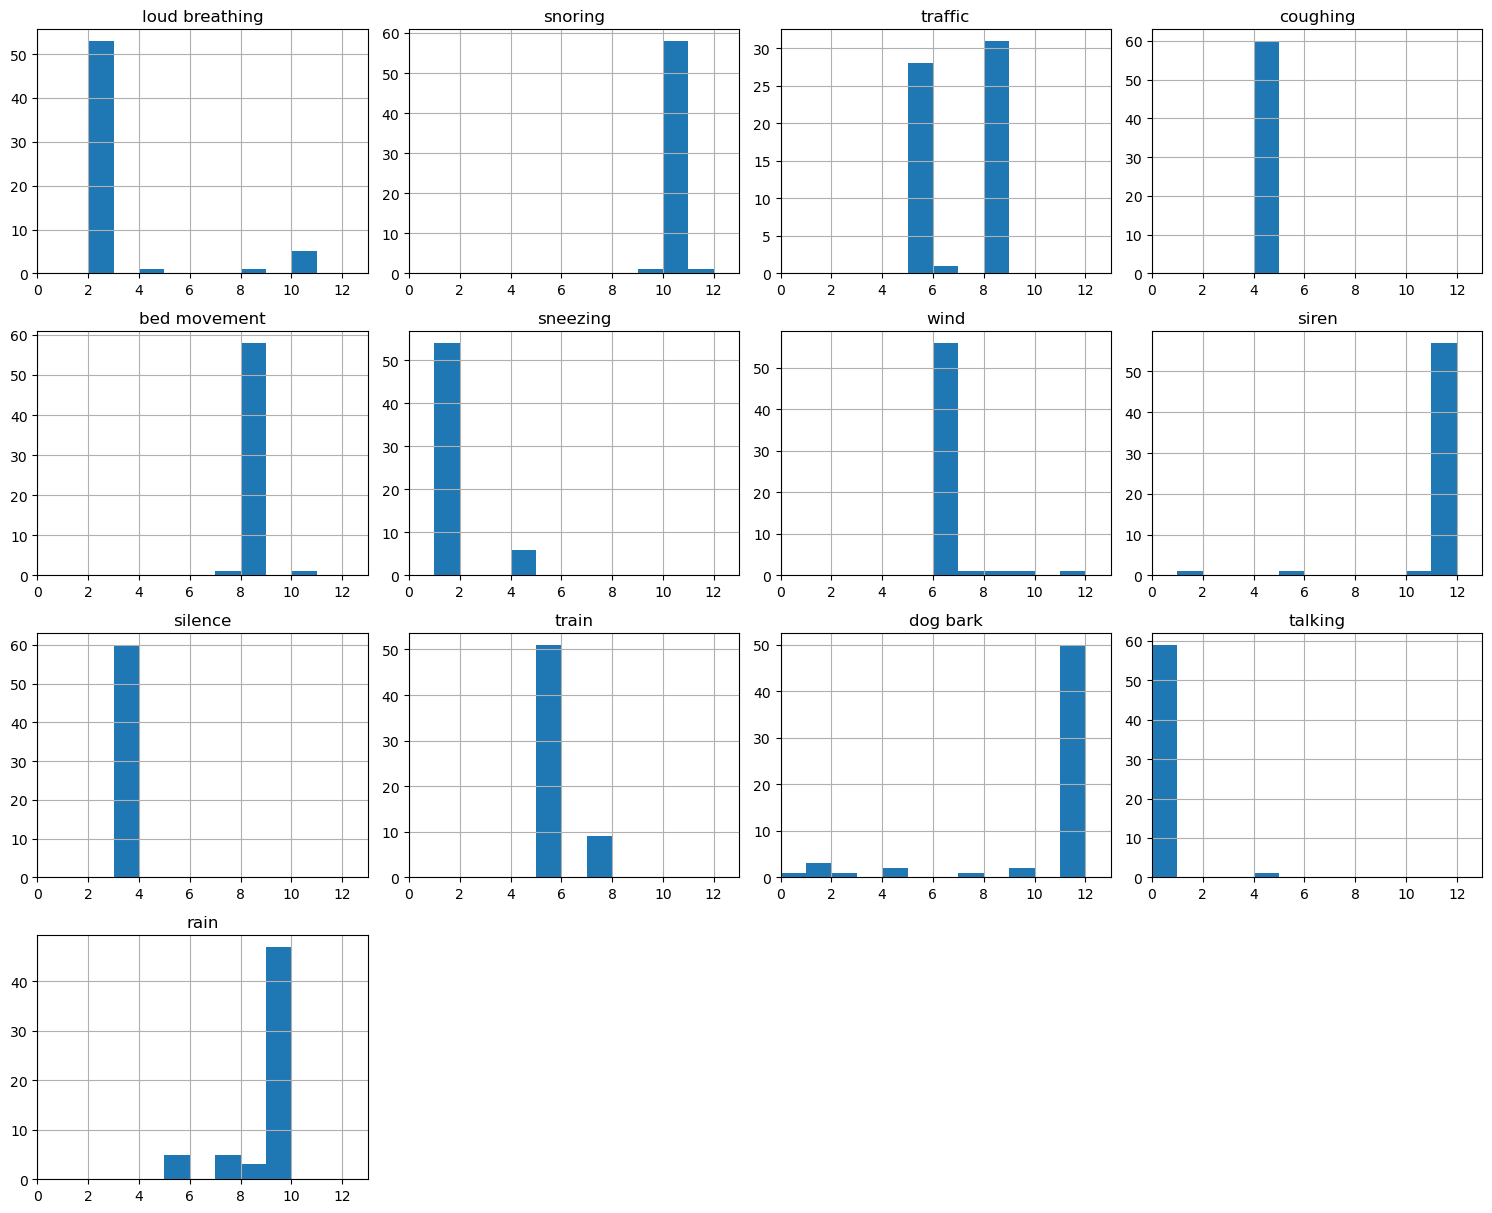

In [40]:
num_images = 4
num_rows = 5  # Increase rows to accommodate 13th class
num_clusters = 13  # Define your total clusters
plt.figure(figsize=(15, 15))
position = 1

# Calculate bin edges for fixed width bars
min_data = df['Predicted Cluster'].min()
max_data = df['Predicted Cluster'].max()
bin_width = 1  # Set the desired bin width
bins = np.arange(min_data, max_data + bin_width, bin_width)  # Calculate bin edges

for i in range(num_rows):
    for j in range(num_images):
        # Break loop if position exceeds the total number of classes
        if position > num_clusters:
            break
        df_cluster = df[df['Label'] == position-1]['Predicted Cluster']

        plt.subplot(num_rows, num_images, position)
        # Pass calculated bins to hist()
        df_cluster.hist(bins=bins)
        if (position-1<13):
            plt.title(reversed_labels[position-1])
        else:
            plt.title(position-1)
        plt.xlim([0, num_clusters])  # Set x-axis limit to the total number of classes
        plt.axis("on")
        plt.tight_layout(pad=1.0)
        position += 1

In [41]:
def stacked_plot(label, row, col):    
    high_values = df_high[df_high['Label']==label]['Predicted Cluster'].value_counts()
    low_values = df_low[df_low['Label']==label]['Predicted Cluster'].value_counts()

    h = np.zeros(13)
    l = np.zeros(13)

    for index in high_values.index:
        h[index] = high_values[index]

    for index in low_values.index:
        l[index] = low_values[index]

    df_view = pd.DataFrame({'High confidence': h,
                       'Low confidence': l})
    
    if (label<13):
        title = reversed_labels[label]
    else:
        title = label
    
    df_view.plot.bar(ax=axarr[row][col], stacked=True, title=title)

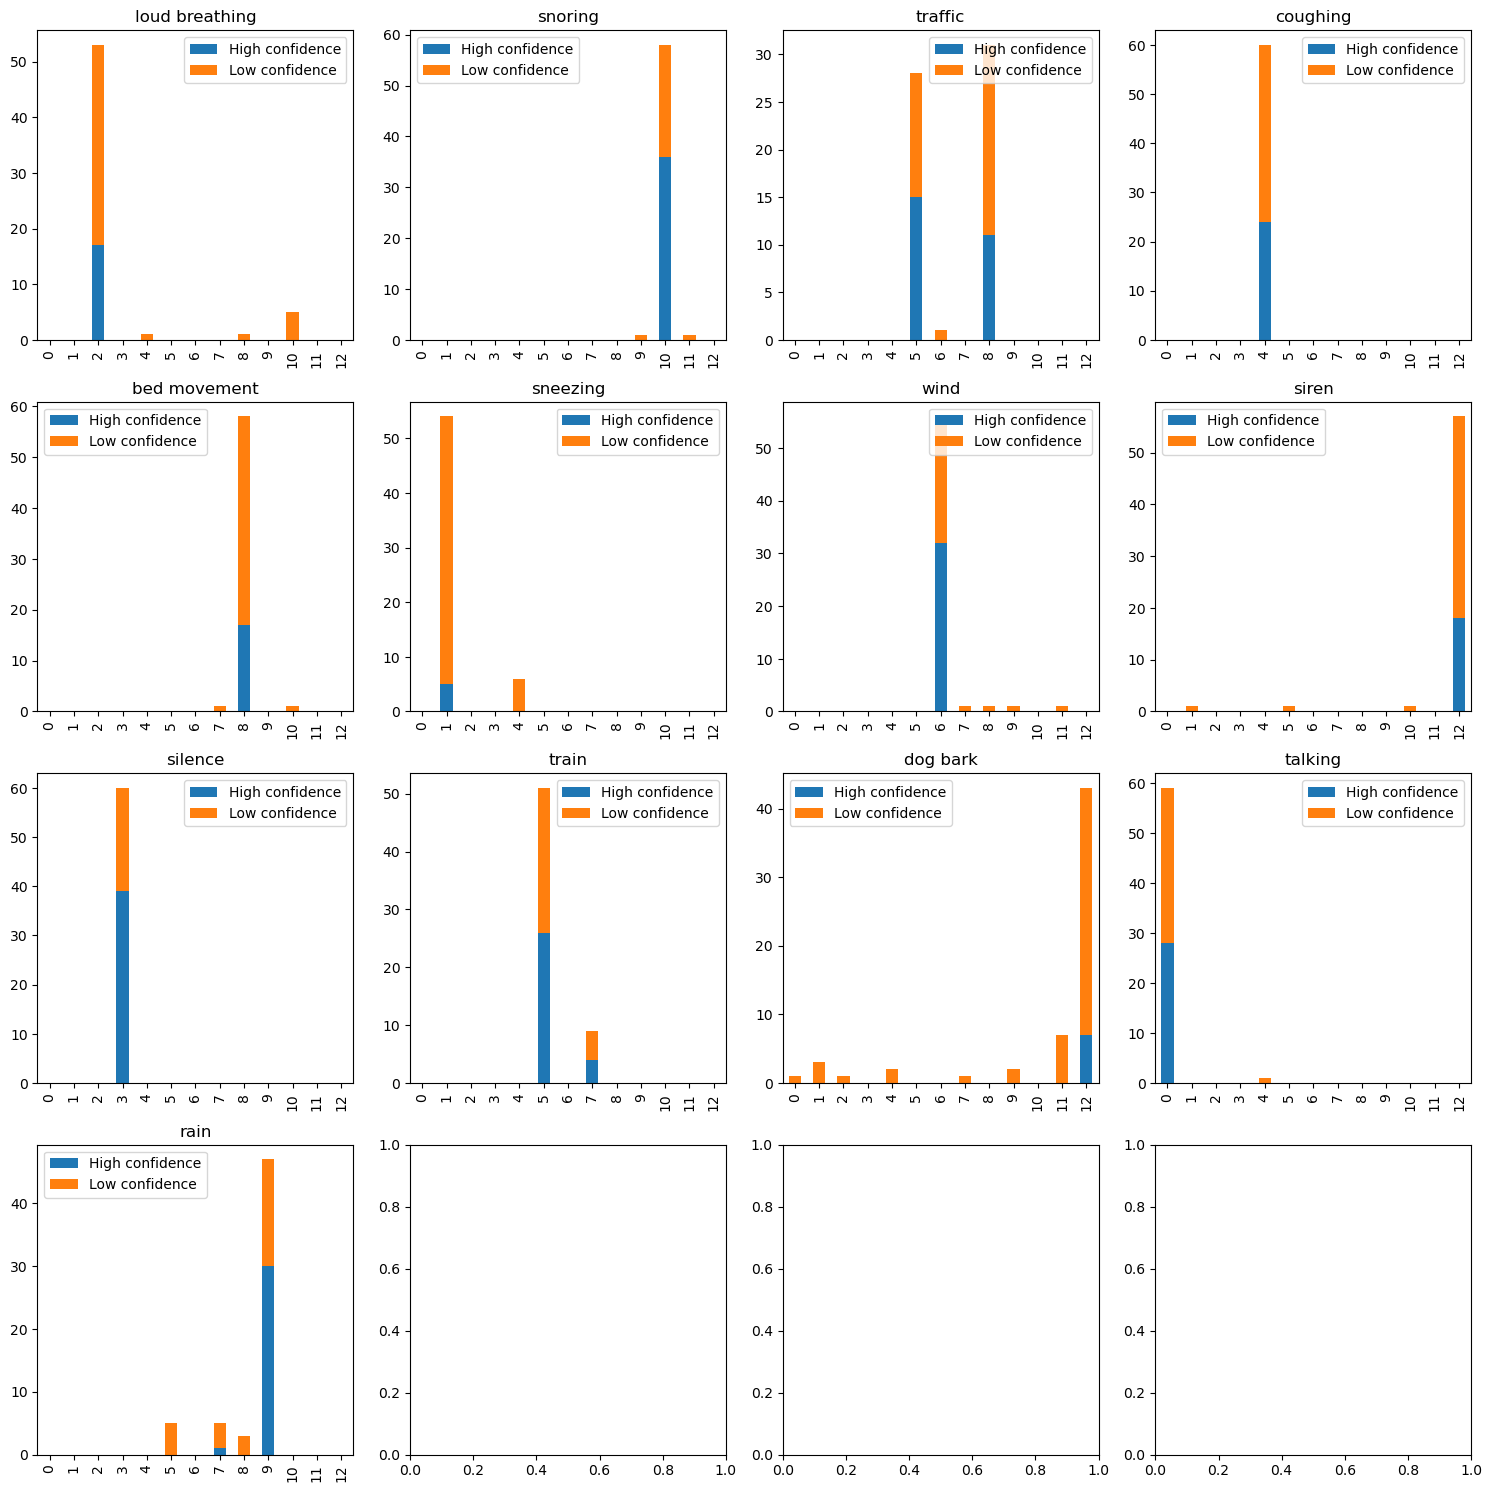

In [42]:
position = 1

fig, axarr = plt.subplots(4, 4, figsize=(15, 15))

num_classes = 13  # Set this to the actual number of classes you have

for i in range(num_rows):
    
    for j in range(num_images):
        
        if position <= num_classes:  # Only plot if position is within the range of available classes
            
            plt.figsize=(5,10)
            stacked_plot(position-1, i, j)
            plt.axis("on")
            plt.tight_layout(pad=1.0)
            
        position += 1

In [43]:
acc = []

for i in range(num_clusters):
    
    df_cluster = df[df['Label'] == i]['Predicted Cluster']
    accuracy = df_cluster.value_counts().max()/df_cluster.value_counts().sum()
    acc.append(accuracy)

accuracy = np.array(acc).mean()

print("Average accuracy is:", accuracy)

Average accuracy is: 0.8807692307692307


### Understanding clusters

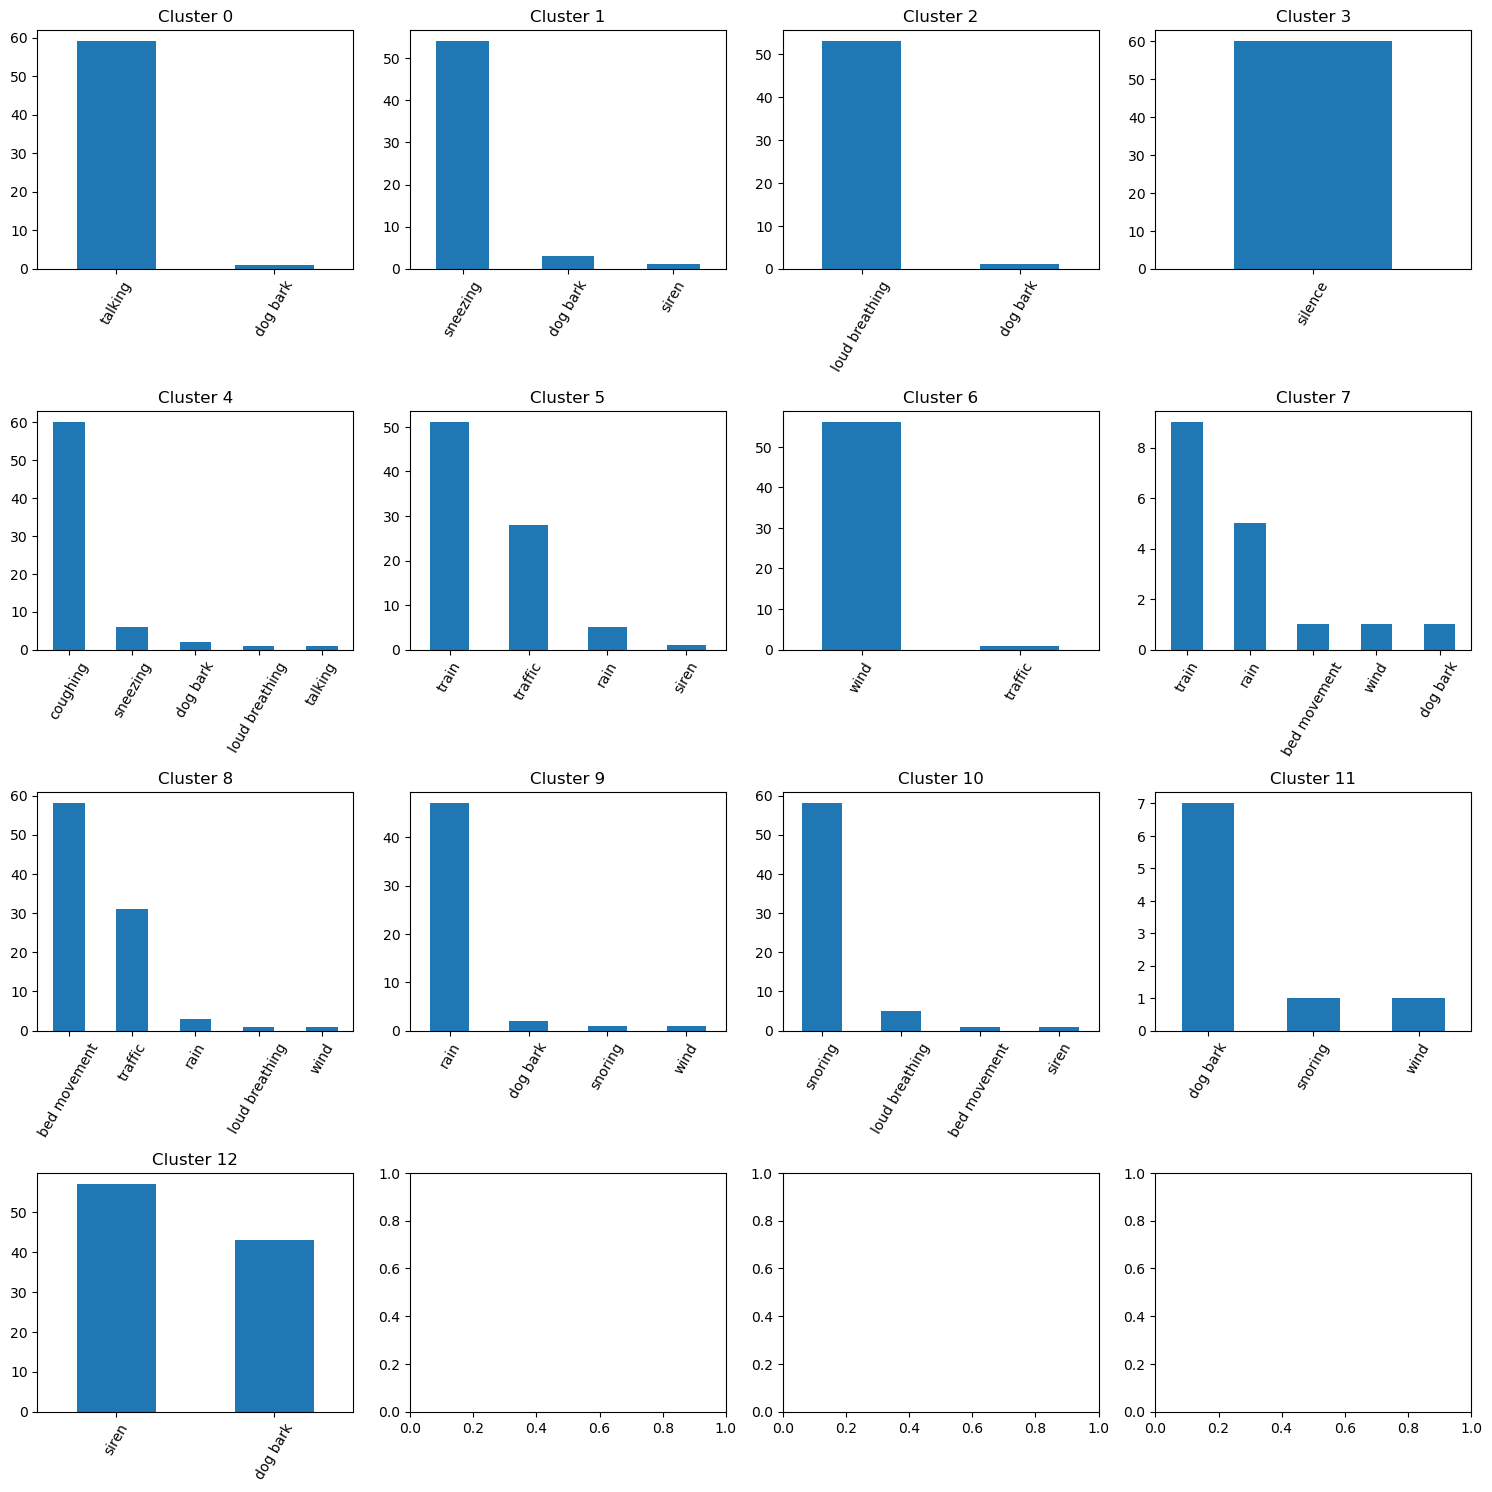

In [44]:
num_rows = 4
num_cols = 4
num_clusters = 13

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,15))

def plot_clusters(cluster):            
    
    cluster_labels = df[df['Predicted Cluster']==cluster]['Label'].value_counts()
    
    return cluster_labels

position = 0

for i in range(num_rows):
    for j in range(num_cols):
        title = ("Cluster " + str(position))
        if position < num_clusters:
            df_predictions = plot_clusters(position)
            df_predictions.plot.bar(ax=axes[i][j], title=title)
            labels = list(df_predictions.index.values)
            labels = [reversed_labels[k] for k in labels]
            axes[i][j].set_xticklabels(labels, rotation=60)
        position+=1

plt.tight_layout(pad=1.0)
plt.show()

https://keras.io/examples/vision/semisupervised_simclr/

# Cluster visualization

In [45]:
feature_vectors.shape

(780, 1024)

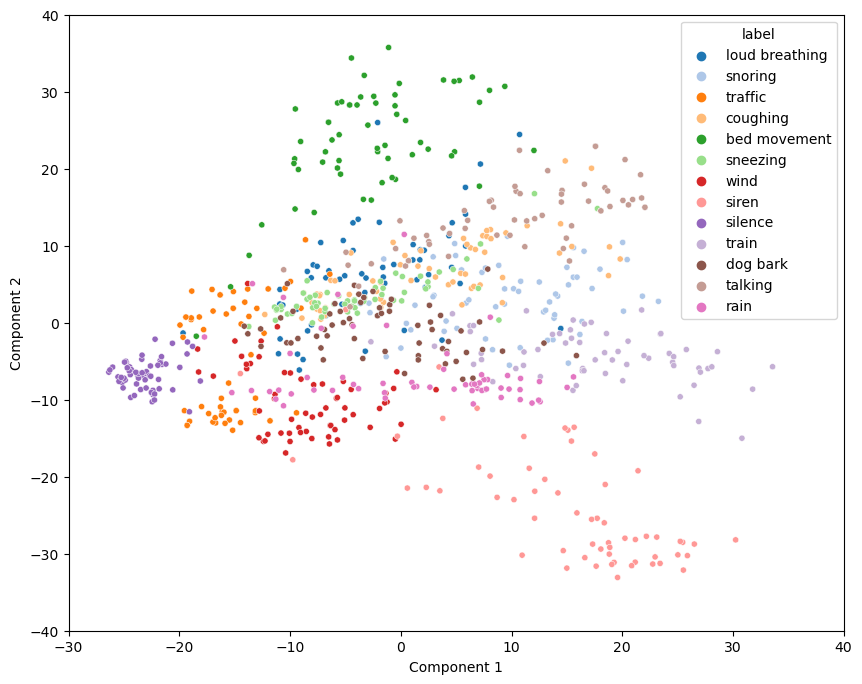

In [57]:
import seaborn as sns
from sklearn.decomposition import PCA

# Create a PCA object for 2D visualization
pca = PCA(n_components=2)

# Fit and transform the feature vectors to 2D
feature_vectors_2d = pca.fit_transform(feature_vectors)

y_data_words = [reversed_labels[i] for i in y_data]

# Convert into a pandas
y_data_series = pd.Series(y_data_words, name='label')

feature_vectors_df = pd.DataFrame(feature_vectors_2d, columns=['Component 1', 'Component 2'])

data = pd.concat([feature_vectors_df, y_data_series], axis=1)

# Create a scatter plot with Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='Component 1', y='Component 2', hue='label', palette='tab20', s=20)

# Adjust x and y limits
plt.xlim(-30, 40)

plt.ylim(-40, 40)

plt.show()

In [47]:
feature_vectors_2d[1][0]

-8.416649

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


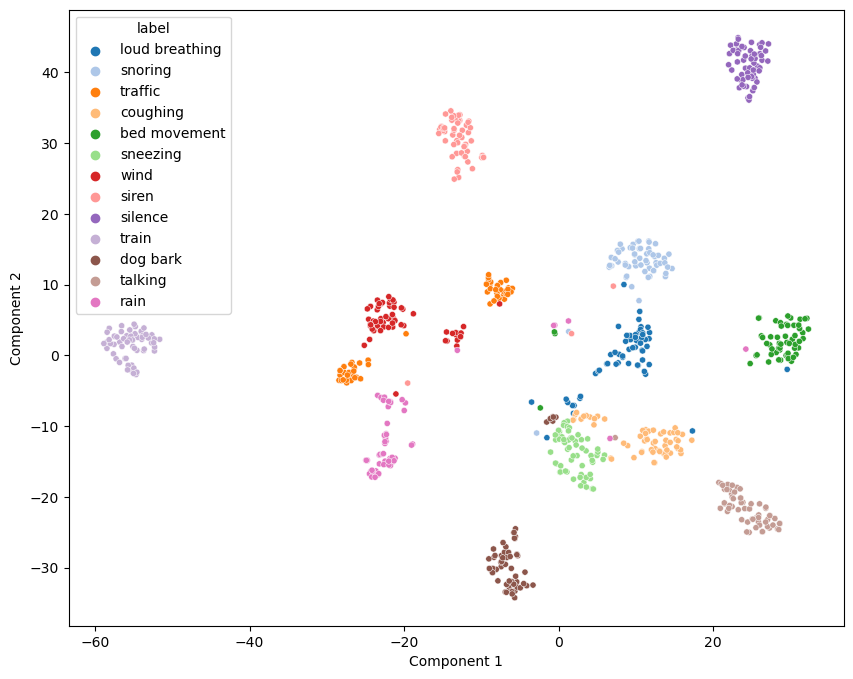

In [48]:
from sklearn.manifold import TSNE

# Create a t-SNE object for 2D visualization
tsne = TSNE(n_components=2, random_state=0)

feature_vectors_2d = tsne.fit_transform(feature_vectors)

y_data_words = [reversed_labels[i] for i in y_data]

y_data_series = pd.Series(y_data_words, name='label')

feature_vectors_df = pd.DataFrame(feature_vectors_2d, columns=['Component 1', 'Component 2'])

data = pd.concat([feature_vectors_df, y_data_series], axis=1)

# Create a scatter plot with Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='Component 1', y='Component 2', hue='label', palette='tab20', s=20)

plt.show()

## Dealing with unkwown sounds

In [49]:
GARBAGE_FOLDER = '/kaggle/input/garbage-truck-dataset/garbage truck'

def unknown_wav_loader(directory, sr=SR, normalization=True):
    all_fragments = []
    files = [f for f in os.listdir(directory) if f.endswith('.wav')]
    for file in files:
        file_path = os.path.join(directory, file)
        # Load the audio file
        sample, sample_rate = librosa.load(file_path, sr=sr)
        if normalization:
            # Normalize the waveform
            sample = librosa.util.normalize(sample)
        # Append the sample and its label (folder name) as a tuple
        all_fragments.append((sample, os.path.basename(directory)))
    return all_fragments

garbage_wav_dataset = unknown_wav_loader(GARBAGE_FOLDER, normalization=False)

In [50]:
len(garbage_wav_dataset)

23

In [51]:
X_garbage = [wav[0] for wav in garbage_wav_dataset]
y_garbage = [wav[1] for wav in garbage_wav_dataset]

X_specs_garbage = list(map(lambda x: tf_mel_spectrogram(x), X_garbage))

In [52]:
x_garbage = np.array(X_specs_garbage)

batch_size = len(x_garbage)

# Get the feature vector representations of the images.
feature_vectors_garbage = encoder.predict(x_garbage, batch_size=batch_size, verbose=1)

1/1 [==============================] - 1s 1s/step


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


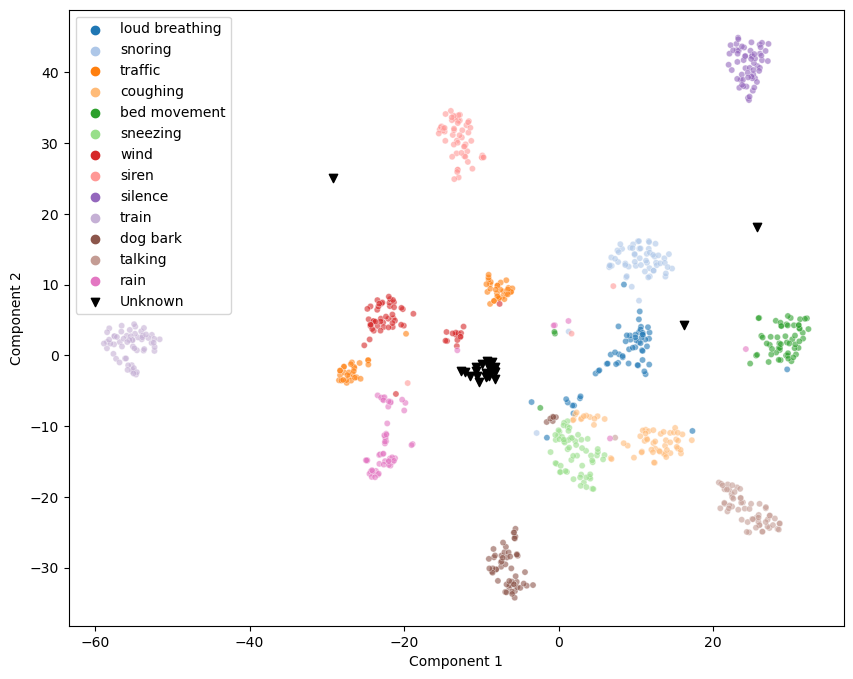

In [53]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(n_components=2, random_state=0)
feature_vectors_2d = tsne.fit_transform(feature_vectors)

y_data_words = [reversed_labels[i] for i in y_data]

y_data_series = pd.Series(y_data_words, name='label')

feature_vectors_df = pd.DataFrame(feature_vectors_2d, columns=['Component 1', 'Component 2'])

data = pd.concat([feature_vectors_df, y_data_series], axis=1)

tsne.n_iter_without_progress = 300
feature_vectors_garbage_2d = tsne.fit_transform(np.concatenate([feature_vectors, feature_vectors_garbage]))[len(feature_vectors):]

feature_vectors_garbage_df = pd.DataFrame(feature_vectors_garbage_2d, columns=['Component 1', 'Component 2'])
feature_vectors_garbage_df['label'] = 'Unknown'

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='Component 1', y='Component 2', hue='label', palette='tab20', s=20, alpha=0.6)
plt.scatter(feature_vectors_garbage_df['Component 1'], feature_vectors_garbage_df['Component 2'], color='black', marker='v', label='Unknown')
plt.legend(loc='best')
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


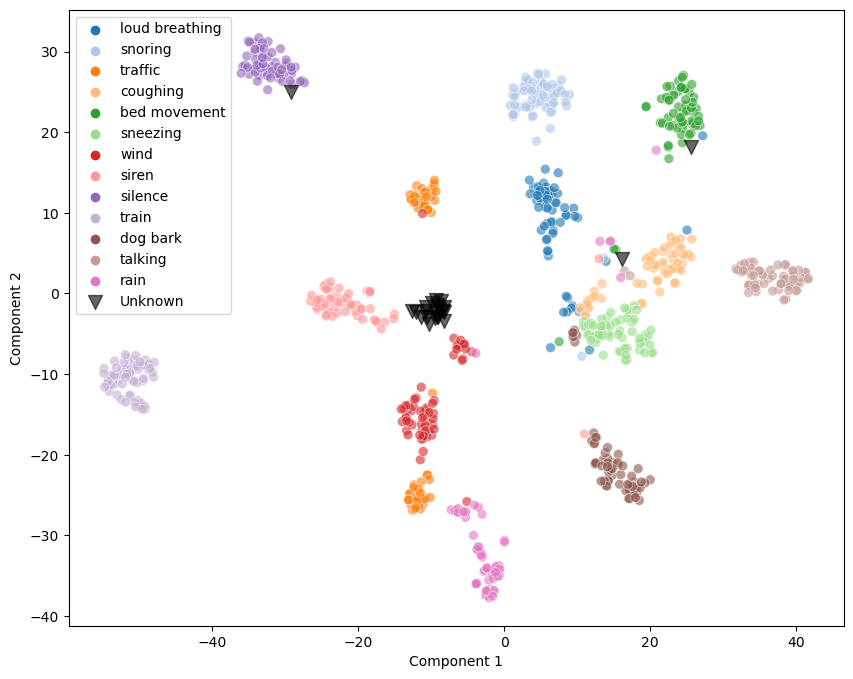

In [61]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Concatenate known and unknown sounds
all_feature_vectors = np.concatenate([feature_vectors, feature_vectors_garbage])

# Create a t-SNE object
tsne = TSNE(n_components=2, random_state=0)

all_feature_vectors_2d = tsne.fit_transform(all_feature_vectors)

feature_vectors_2d = all_feature_vectors_2d[:len(feature_vectors)]
feature_vectors_garbage_2d = all_feature_vectors_2d[len(feature_vectors):]

y_data_words = [reversed_labels[i] for i in y_data]
y_garbage = ['Unknown'] * len(feature_vectors_garbage_2d)

y_data_series = pd.Series(y_data_words, name='label')
y_garbage_series = pd.Series(y_garbage, name='label')

feature_vectors_df = pd.DataFrame(feature_vectors_2d, columns=['Component 1', 'Component 2'])
feature_vectors_garbage_df = pd.DataFrame(feature_vectors_garbage_2d, columns=['Component 1', 'Component 2'])

# Concatenate your DataFrame and Series together
data_known = pd.concat([feature_vectors_df, y_data_series], axis=1)
data_unknown = pd.concat([feature_vectors_garbage_df, y_garbage_series], axis=1)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=data_known, x='Component 1', y='Component 2', hue='label', palette='tab20', s=50, alpha=0.6)

plt.scatter(data_unknown['Component 1'], data_unknown['Component 2'], color='black', marker='v', s=100, alpha=0.6, label='Unknown')

plt.legend(loc='best')
plt.show()

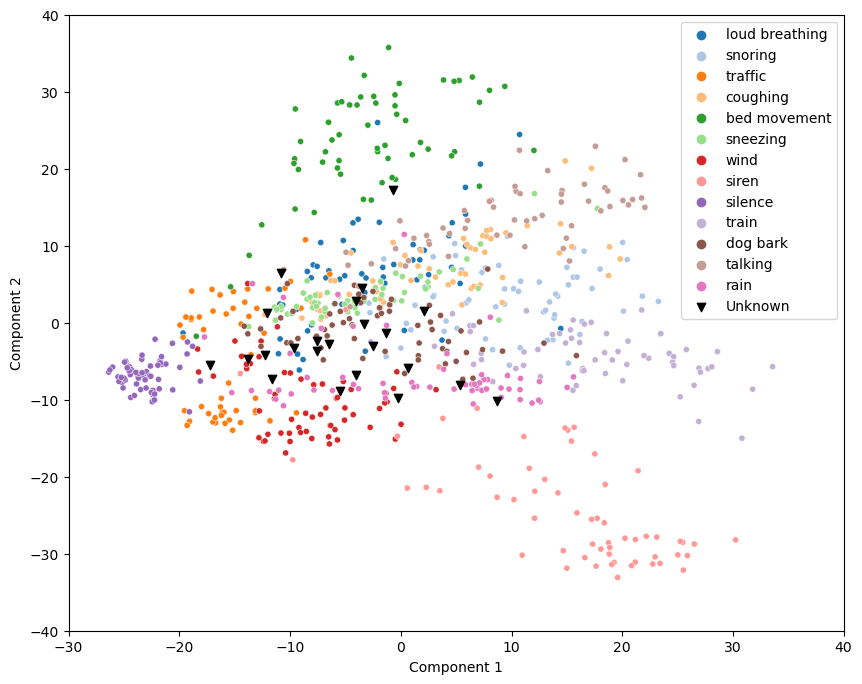

In [58]:
import seaborn as sns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

feature_vectors_2d = pca.fit_transform(feature_vectors)

y_data_words = [reversed_labels[i] for i in y_data]

y_data_series = pd.Series(y_data_words, name='label')

feature_vectors_df = pd.DataFrame(feature_vectors_2d, columns=['Component 1', 'Component 2'])

data = pd.concat([feature_vectors_df, y_data_series], axis=1)

feature_vectors_garbage_2d = pca.transform(np.concatenate([feature_vectors, feature_vectors_garbage]))[len(feature_vectors):]

feature_vectors_garbage_df = pd.DataFrame(feature_vectors_garbage_2d, columns=['Component 1', 'Component 2'])
feature_vectors_garbage_df['label'] = 'Unknown'

plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='Component 1', y='Component 2', hue='label', palette='tab20', s=20)
plt.scatter(feature_vectors_garbage_df['Component 1'], feature_vectors_garbage_df['Component 2'], color='black', marker='v', label='Unknown')

# Adjust x and y limits
plt.xlim(-30, 40)
plt.ylim(-40, 40)

plt.legend(loc='best')
plt.show()

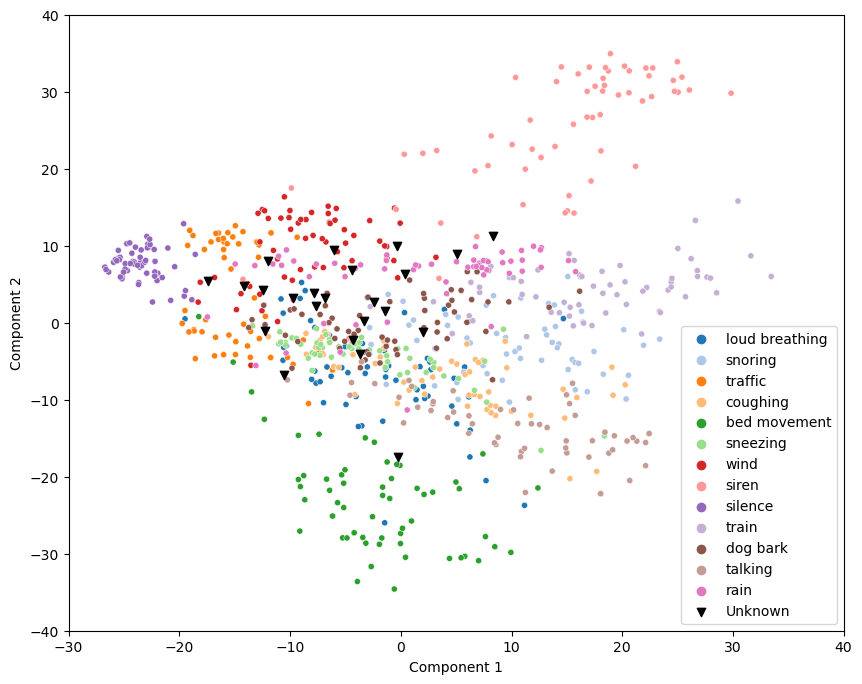

In [59]:
import seaborn as sns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

all_feature_vectors = np.concatenate([feature_vectors, feature_vectors_garbage])

all_feature_vectors_2d = pca.fit_transform(all_feature_vectors)

feature_vectors_2d = all_feature_vectors_2d[:len(feature_vectors)]
feature_vectors_garbage_2d = all_feature_vectors_2d[len(feature_vectors):]

y_data_words = [reversed_labels[i] for i in y_data]

y_data_series = pd.Series(y_data_words, name='label')

feature_vectors_df = pd.DataFrame(feature_vectors_2d, columns=['Component 1', 'Component 2'])

data = pd.concat([feature_vectors_df, y_data_series], axis=1)

feature_vectors_garbage_df = pd.DataFrame(feature_vectors_garbage_2d, columns=['Component 1', 'Component 2'])
feature_vectors_garbage_df['label'] = 'Unknown'

plt.figure(figsize=(10, 8)) 
sns.scatterplot(data=data, x='Component 1', y='Component 2', hue='label', palette='tab20', s=20)
plt.scatter(feature_vectors_garbage_df['Component 1'], feature_vectors_garbage_df['Component 2'], color='black', marker='v', label='Unknown')

# Adjust x and y limits
plt.xlim(-30, 40)
plt.ylim(-40, 40)

plt.legend(loc='best')
plt.show()

In [55]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(x_garbage, batch_size=batch_size, verbose=1)

# Get the cluster of the highest probability.
cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()

# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.

cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()

1/1 [==============================] - 1s 677ms/step


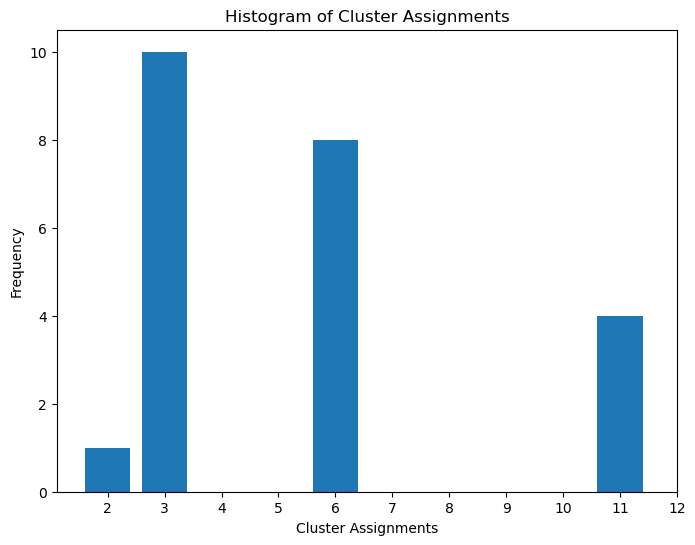

In [56]:
# Creating the histogram
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.hist(cluster_assignments, bins=range(min(cluster_assignments), max(cluster_assignments) + 2), align='left', rwidth=0.8)

# Adding labels and title
plt.xlabel('Cluster Assignments')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Assignments')

# Setting x-axis ticks
plt.xticks(range(min(cluster_assignments), 13))

# Displaying the histogram
plt.show()

In [60]:
cluster_confidence

array([0.305868  , 0.17564857, 0.27810213, 0.437121  , 0.23235926,
       0.1878283 , 0.43534312, 0.18747064, 0.3310296 , 0.4456293 ,
       0.36667252, 0.24548574, 0.3053622 , 0.27952886, 0.2153123 ,
       0.28975683, 0.26005575, 0.36511028, 0.46973056, 0.26556757,
       0.3106618 , 0.22842917, 0.21205252], dtype=float32)

## Retraining the cluster model with the garbage data

In [68]:
y_garbage = [13 for wav in garbage_wav_dataset]

# Convert lists to NumPy arrays
X_specs_arr = np.array(X_specs)
X_garbage_arr = np.array(X_specs_garbage)

# Combine the data arrays
x_data = np.vstack((X_specs_arr, X_garbage_arr))

# Assuming y_data and y_garbage are already defined
# Combine the label arrays
y_data = np.concatenate((y_data, y_garbage), axis=0)

In [102]:
# get unique classes
unique_classes = np.unique(y_data)

# initiate an empty dictionary to store indices of each class
indices = {c: np.where(y_data == c)[0] for c in unique_classes}

# sample 23 indices from each class
sample_indices = [np.random.choice(indices[c], 23, replace=False) for c in unique_classes]

# flatten the list of indices
sample_indices = [index for class_indices in sample_indices for index in class_indices]

# gather samples from x_data
x_data_sample = x_data[sample_indices]

# gather corresponding labels from y_data
y_data_sample = y_data[sample_indices]

In [107]:
x_data = np.array(x_data_sample)
y_data = np.array(y_data_sample)

### Compute the nearest neighbors

In [108]:
num_clusters = NUM_CLASSES  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

In [109]:
batch_size = len(x_data)

# Get the feature vector representations of the images.
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
#feature_vectors = tf.math.l2_normalize(feature_vectors, -1)

1/1 [==============================] - 4s 4s/step


In [110]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size

for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])
    
neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))

100%|██████████| 1/1 [00:00<00:00, 244.31it/s]


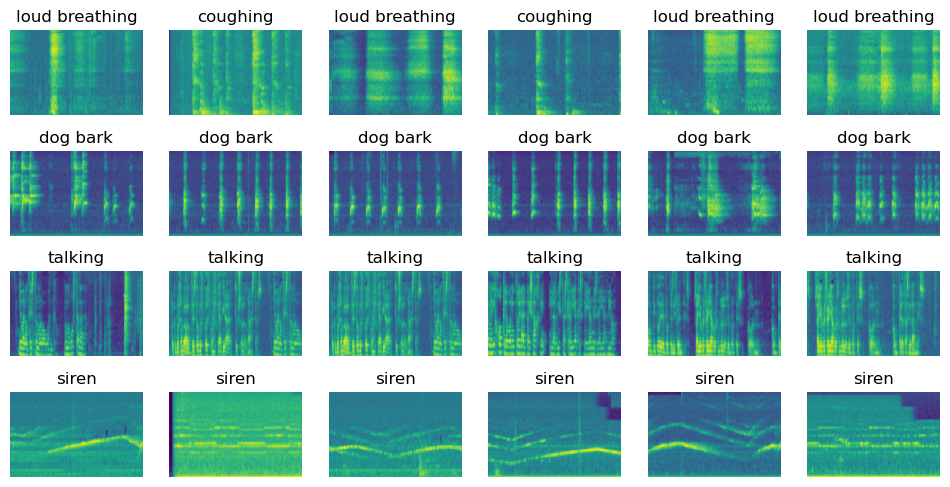

In [111]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 6))
position = 1

for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_data.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        # Select one channel (channel 0), rotate and display with viridis colormap.
        plt.imshow(np.rot90(x_data[indices[j], :, :, 0]), cmap='viridis', aspect=5)
        plt.title(reversed_labels[y_data[indices[j]]])
        plt.axis("off")
        position += 1
        
plt.savefig('foo.png')

### Clustering model

In [112]:
class ClustersConsistencyLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = tf.ones_like(similarity)
        # Compute cross entropy loss.
        loss = tf.keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return tf.math.reduce_mean(loss)

In [113]:
class ClustersEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super().__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = tf.cast(tf.shape(cluster_probabilities)[-1], tf.dtypes.float32)
        target = tf.math.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = tf.math.reduce_mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = tf.clip_by_value(
            cluster_probabilities, clip_value_min=1e-8, clip_value_max=1.0
        )
        # Compute the entropy over the clusters.
        entropy = -tf.math.reduce_sum(
            cluster_probabilities * tf.math.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss

In [114]:
def create_clustering_model(encoder, num_clusters, name=None):
    inputs = tf.keras.Input(shape=input_shape)
    # Preprocess the input images.
    #preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    #augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(inputs)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [115]:
def create_clustering_learner(clustering_model):
    anchor = tf.keras.Input(shape=input_shape, name="anchors")
    neighbours = tf.keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = tf.reshape(neighbours, shape=tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = tf.reshape(
        neighbours_clustering,
        shape=(-1, k_neighbours, tf.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = tf.linalg.einsum(
        "bij,bkj->bik", tf.expand_dims(anchor_clustering, axis=1), neighbours_clustering
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="similarity")(
        similarity
    )
    # Create the model.
    model = tf.keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model

In [116]:
input_shape = x_data[0].shape

Fine tunning: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [117]:
for l in encoder.layers:
    print(l.name, l.trainable)

mobilenet_1.00_224_input False
mobilenet_1.00_224 False
global_average_pooling2d False


In [118]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.

for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
    
# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)

# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]

# Create the model inputs and labels.
inputs = {"anchors": x_data, "neighbours": tf.gather(x_data, neighbours)}
labels = tf.ones(shape=(x_data.shape[0]))

# Compile the model.
clustering_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0005/2, weight_decay=0.0001*2),
    loss=losses,
)

# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=25, epochs=100)

Epoch 1/100
13/13 [==============================] - 7s 306ms/step - loss: 0.7687 - similarity_loss: 0.5739 - clustering_loss: 0.1948
Epoch 2/100
13/13 [==============================] - 1s 111ms/step - loss: 0.6820 - similarity_loss: 0.5742 - clustering_loss: 0.1078
Epoch 3/100
13/13 [==============================] - 1s 103ms/step - loss: 0.6374 - similarity_loss: 0.5691 - clustering_loss: 0.0683
Epoch 4/100
13/13 [==============================] - 1s 107ms/step - loss: 0.6423 - similarity_loss: 0.5614 - clustering_loss: 0.0809
Epoch 5/100
13/13 [==============================] - 2s 118ms/step - loss: 0.6157 - similarity_loss: 0.5575 - clustering_loss: 0.0582
Epoch 6/100
13/13 [==============================] - 1s 107ms/step - loss: 0.6191 - similarity_loss: 0.5428 - clustering_loss: 0.0763
Epoch 7/100
13/13 [==============================] - 1s 107ms/step - loss: 0.6196 - similarity_loss: 0.5334 - clustering_loss: 0.0861
Epoch 8/100
13/13 [==============================] - 1s 106ms/

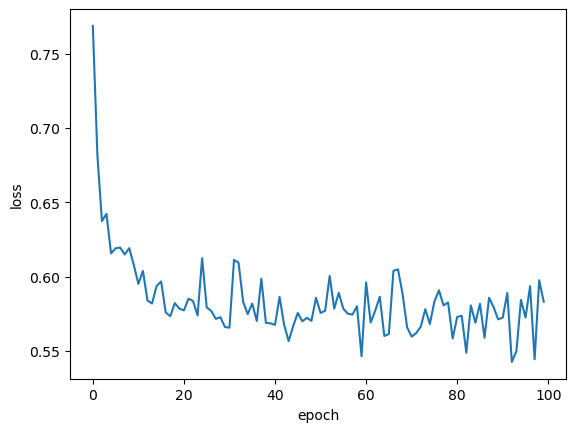

In [119]:
plt.plot(clustering_learner.history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [120]:
clustering_model.summary()

Model: "clustering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 498, 64, 3)]      0         
                                                                 
 model (Functional)          (None, 1024)              3228864   
                                                                 
 dense_2 (Dense)             (None, 13)                13325     
                                                                 
Total params: 3,242,189
Trainable params: 13,325
Non-trainable params: 3,228,864
_________________________________________________________________


In [121]:
clustering_model.save('cluster_model.h5')

In [122]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(x_data, batch_size=batch_size, verbose=1)

# Get the cluster of the highest probability.
cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()

# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.

cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()

1/1 [==============================] - 1s 563ms/step


In [123]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))

cluster 0 : 27
cluster 1 : 29
cluster 2 : 29
cluster 3 : 15
cluster 4 : 25
cluster 5 : 13
cluster 6 : 23
cluster 7 : 23
cluster 8 : 23
cluster 9 : 25
cluster 10 : 24
cluster 11 : 28
cluster 12 : 38


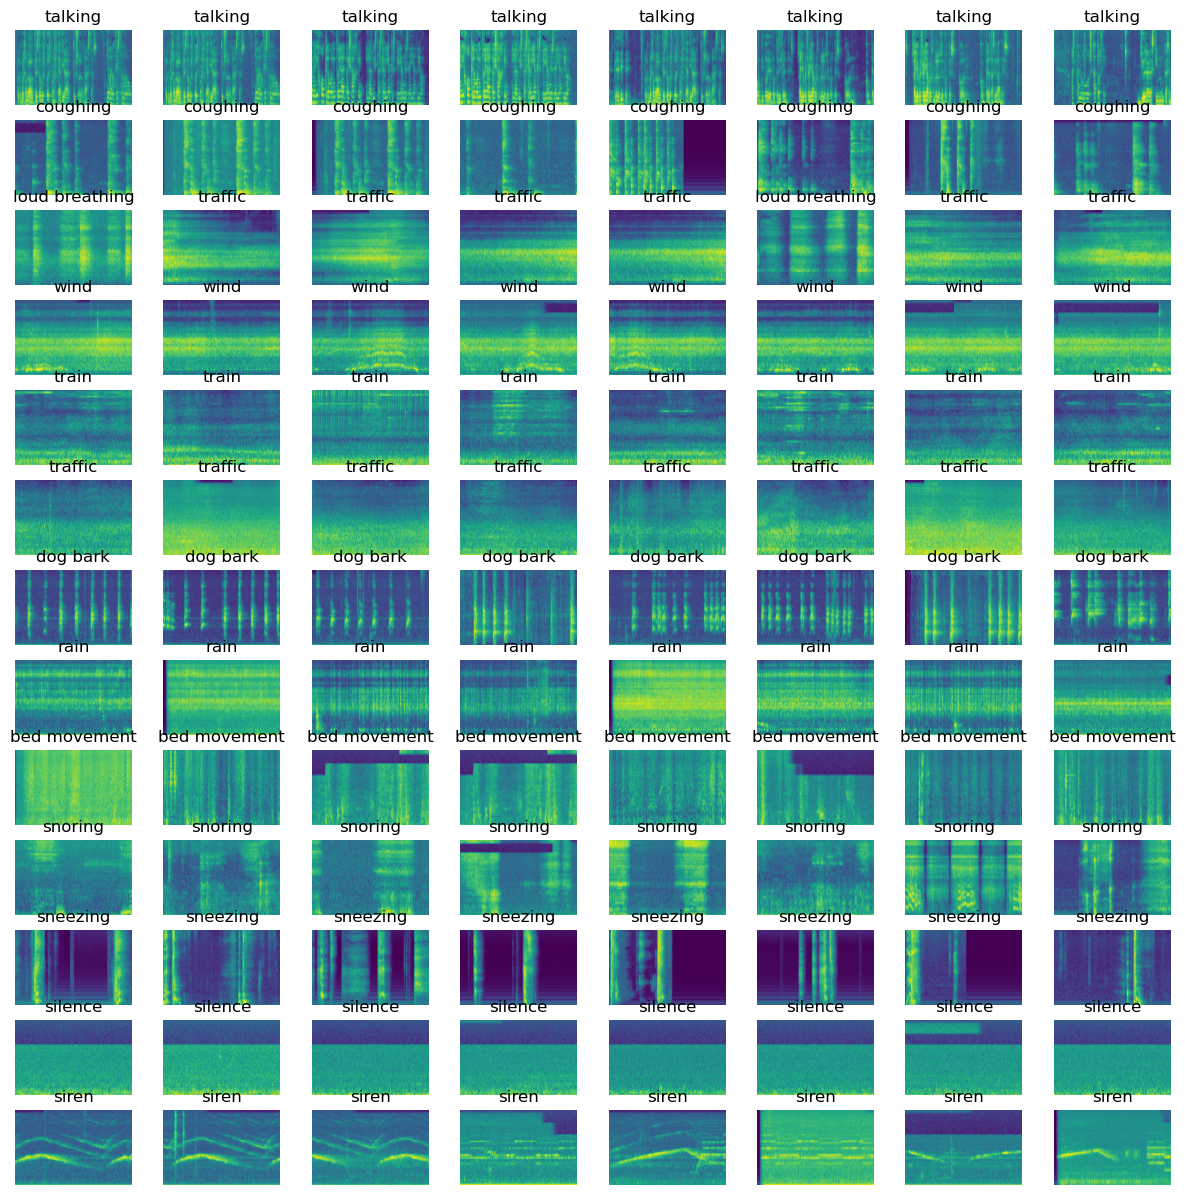

In [124]:
num_images = 8
plt.figure(figsize=(15, 15))
position = 1

for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(num_clusters, num_images, position)
        # Select one channel (channel 0), rotate and display with viridis colormap.
        plt.imshow(np.rot90(x_data[image_idx, :, :, 0]), cmap='viridis', aspect=5)
        plt.title(reversed_labels[y_data[image_idx]])
        plt.axis("off")
        position += 1

plt.savefig('final_clusters.png')

In [125]:
cluster_eval = []

for i in range(len(clusters)):
    for item in clusters[i]:
        cluster_eval.append((y_data[item[0]],i,item[1])) # (True label, predicted cluster)

df = pd.DataFrame(cluster_eval, columns=['Label', 'Predicted Cluster', 'Confidence'])

df.head()

Label  Predicted Cluster  Confidence
0     11                  0    0.693856
1     11                  0    0.545376
2     11                  0    0.918936
3     11                  0    0.483323
4     11                  0    0.504002

In [126]:
df_high = df[df['Confidence'] > 0.8]
df_low = df[df['Confidence'] <= 0.8]

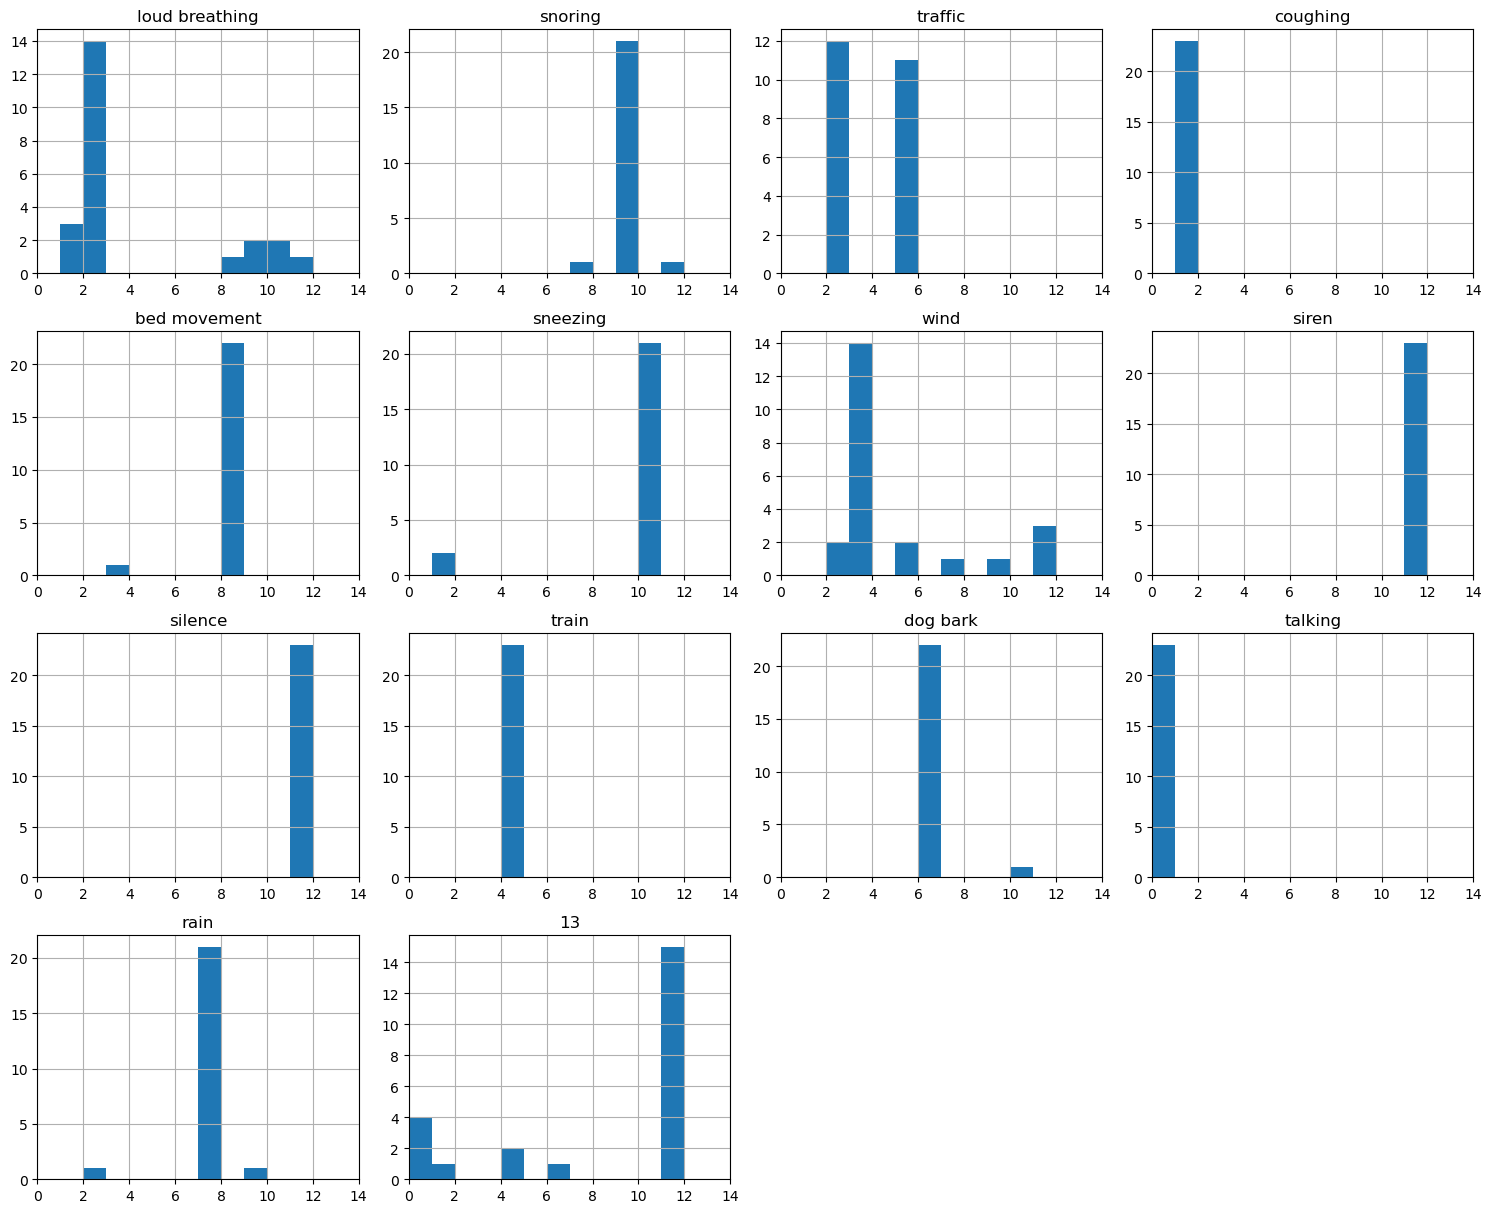

In [127]:
num_images = 4
num_rows = 5  # Increase rows to accommodate 13th class
num_clusters = 14  # Define your total clusters
plt.figure(figsize=(15, 15))
position = 1

# Calculate bin edges for fixed width bars
min_data = df['Predicted Cluster'].min()
max_data = df['Predicted Cluster'].max()
bin_width = 1  # Set the desired bin width
bins = np.arange(min_data, max_data + bin_width, bin_width)  # Calculate bin edges

for i in range(num_rows):
    for j in range(num_images):
        # Break loop if position exceeds the total number of classes
        if position > num_clusters:
            break
        df_cluster = df[df['Label'] == position-1]['Predicted Cluster']

        plt.subplot(num_rows, num_images, position)
        # Pass calculated bins to hist()
        df_cluster.hist(bins=bins)
        if (position-1<13):
            plt.title(reversed_labels[position-1])
        else:
            plt.title(position-1)
        plt.xlim([0, num_clusters])  # Set x-axis limit to the total number of classes
        plt.axis("on")
        plt.tight_layout(pad=1.0)
        position += 1

In [128]:
def stacked_plot(label, row, col):    
    high_values = df_high[df_high['Label']==label]['Predicted Cluster'].value_counts()
    low_values = df_low[df_low['Label']==label]['Predicted Cluster'].value_counts()

    h = np.zeros(13)
    l = np.zeros(13)

    for index in high_values.index:
        h[index] = high_values[index]

    for index in low_values.index:
        l[index] = low_values[index]

    df_view = pd.DataFrame({'High confidence': h,
                       'Low confidence': l})
    
    if (label<13):
        title = reversed_labels[label]
    else:
        title = 'Unknown'
    
    df_view.plot.bar(ax=axarr[row][col], stacked=True, title=title)

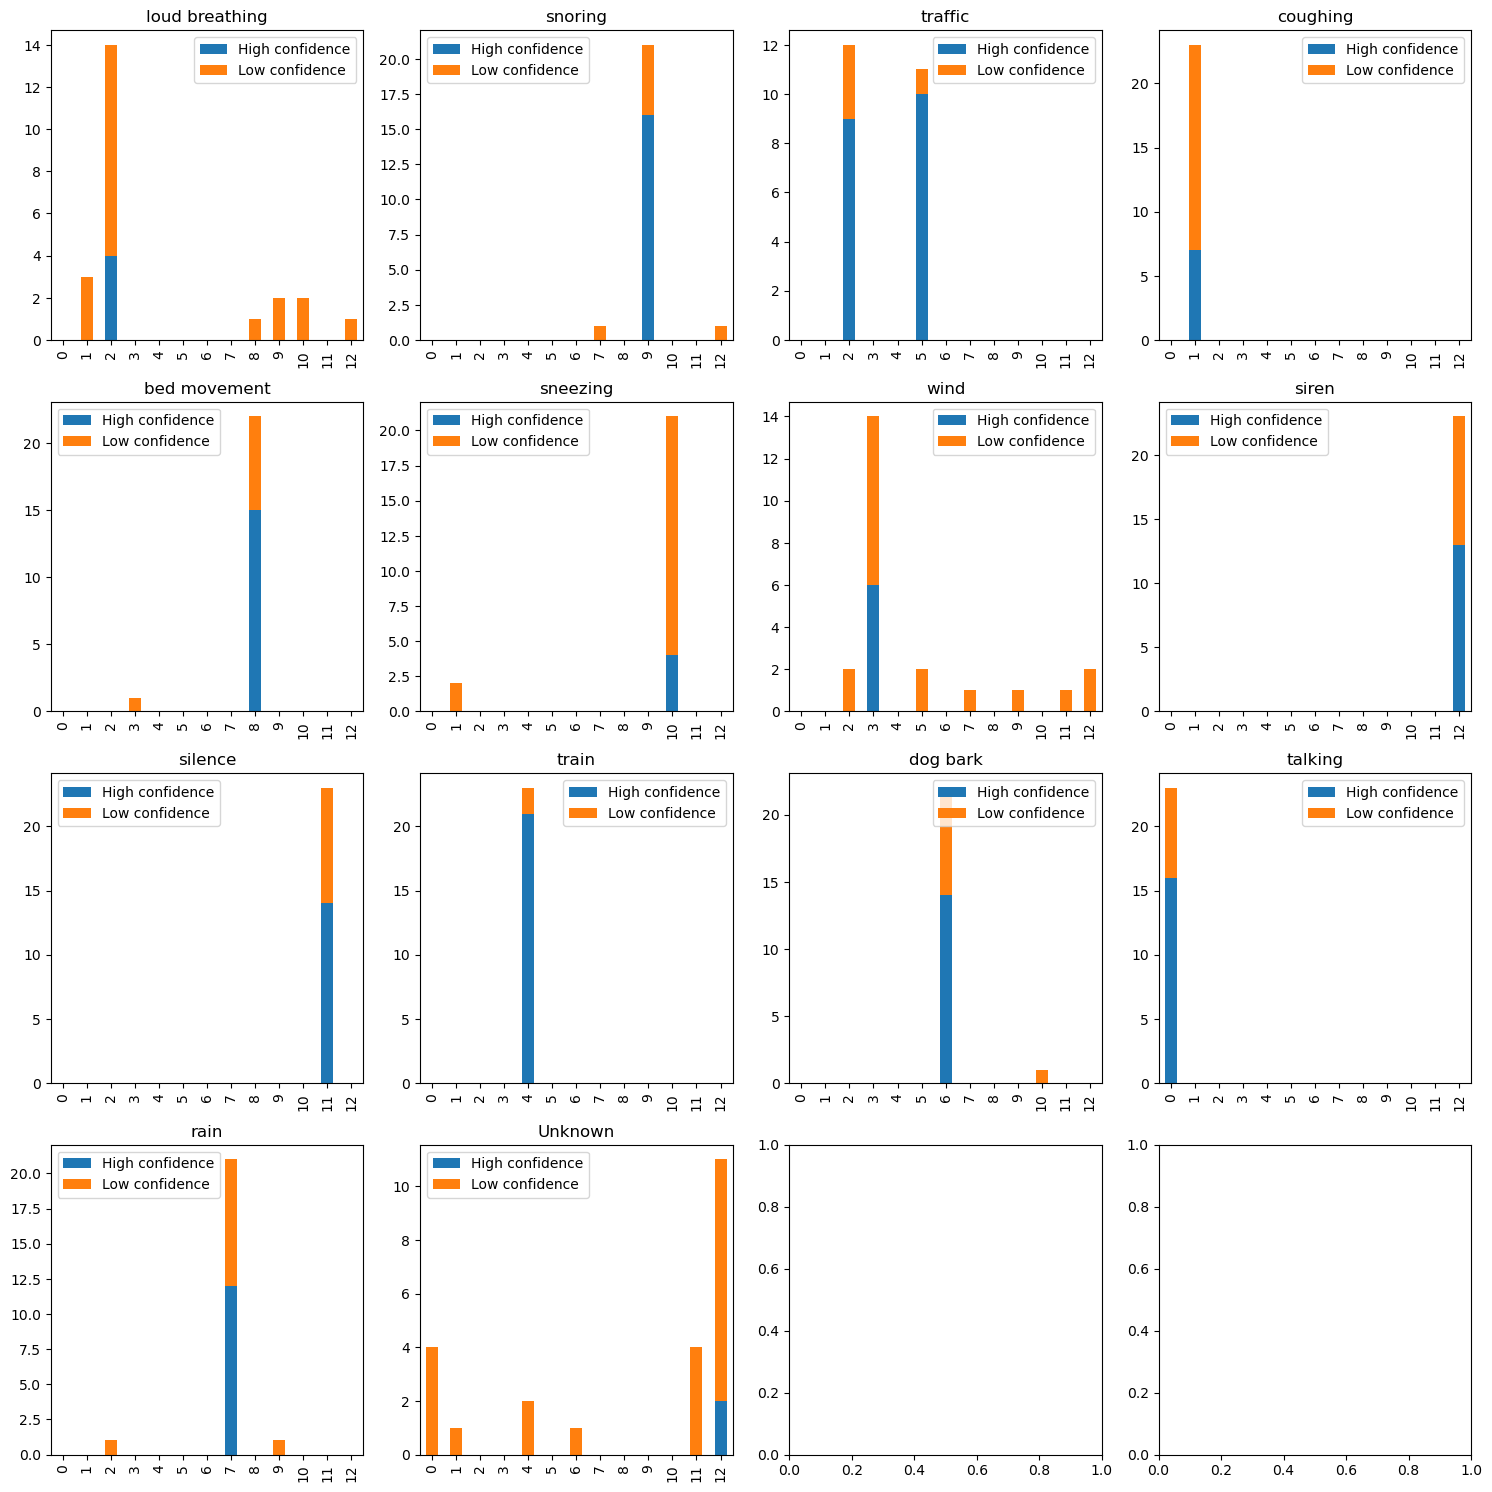

In [129]:
position = 1

fig, axarr = plt.subplots(4, 4, figsize=(15, 15))

num_classes = 14  # Set this to the actual number of classes

for i in range(num_rows):
    
    for j in range(num_images):
        
        if position <= num_classes:  # Only plot if position is within the range of available classes
            
            plt.figsize=(5,10)
            stacked_plot(position-1, i, j)
            plt.axis("on")
            plt.tight_layout(pad=1.0)
            
        position += 1

In [130]:
acc = []

for i in range(num_clusters):
    
    df_cluster = df[df['Label'] == i]['Predicted Cluster']
    accuracy = df_cluster.value_counts().max()/df_cluster.value_counts().sum()
    acc.append(accuracy)

accuracy = np.array(acc).mean()

print("Average accuracy is:", accuracy)

Average accuracy is: 0.8478260869565217
